# Data Exploration

We'll explore three areas of the data:

1. Article and Summary length statistics as measured in number of sentences
2. Inclusion of the article's leading sentences in the summary 
3. Visualization of articles in embedding space by subject domain

Before doing so, we will start by loading the data and checking the keys of the primary data structures:

In [2]:
import pandas as pd

input_file = 'train_test_set20_embeddings_domain_labels.pickle'
data = pd.read_pickle(input_file )

df = data['df_original']

In [3]:
data.keys()

dict_keys(['df_original', 'Xy_doc_label_array', 'df_X', 'y_array', 'domain_labels_arr', 'train_test_sets'])

In [4]:
df.columns

Index(['url', 'archive', 'title', 'date', 'text', 'summary', 'compression',
       'coverage', 'density', 'compression_bin', 'coverage_bin', 'density_bin',
       'text_clean', 'text_embedding', 'summary_clean', 'summary_embedding',
       'labels', 'labels_idx_list'],
      dtype='object')

### Article and Summary Length

We'll start by looking at article length in number of sentences

In [5]:
sent_length = pd.DataFrame(df.text_clean.apply(len).values, columns=['Article'])
sent_length['Summary'] = df.summary_clean.apply(len) 
pd.DataFrame(sent_length.mean().apply(lambda x: round(x,3)), columns = ['mean'])

,mean
Article,33.270
Summary,3.248


In [6]:
#statistics of lengths for each
sent_length_quant = sent_length.quantile([0,0.25,0.5,0.75,0.95,0.99, 1])
sent_length_quant.index.name = 'Percentile'
sent_length_quant.columns.name = 'Number of Sentences'
sent_length_quant


Number of Sentences,Article,Summary
Percentile,,
0.00,1.00,1.0
0.25,15.00,1.0
0.50,26.00,2.0
0.75,42.00,4.0
0.95,76.05,9.0
0.99,151.01,14.0
1.00,843.00,56.0


Article: The mean sentence length is 33 and the median is 26. The right tail shows some heavy outlierswith the 95th to 100th percentile ranging from 151 to 843.

Summary: The mean is 3 and the median is 2 but, more importantly, we see that at least 75% of the summaries ar ebetween 2 and 4 sentences. We also notice heavy outliers between the 99th and 100th percentile ranging from 14 to 56 sentences.

### Article Length vs Summary Length

It seems reasonable to hypothesize that summary length and article length are well correllated. We will test this relationship by fitting a linear regression line and looking at the r-squared.

r_squared =  0.056


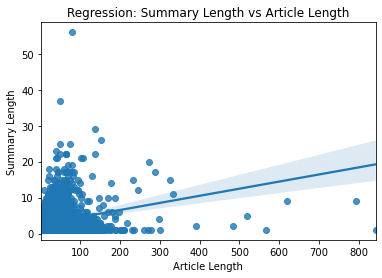

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.regplot(x='Article', y='Summary', data=sent_length);
plt.title('Regression: Summary Length vs Article Length')
plt.xlabel('Article Length')
plt.ylabel('Summary Length')
r_squared_matrix = np.corrcoef(sent_length.Article, sent_length.Summary)**2

print('r_squared = ', round(r_squared_matrix[0][1],3))

While the regression slop is positive the relationship is quite meaningless with an r-squared of only 5%. We also see the slope of the line is highly levered on only a handful of points which can even by counted by hand over a sample of 5,000!

### Publication Breakdown in Sample

In this section we look at an aproximation of the % Breakdown of publications across the corpus. We do this by finding the domain name between "www." and ".com" to identify different publications. This is not exact as some publications will have different domains for different content or publications / blogs/ for exmaple, Fox would have "fox.com" as well as "foxsports.com".


In [8]:
#pull primary domain name by position and find normlaized value count
df_pubs = df.url.apply(lambda x: x[x.find('www.')+4 : x.find('.com')]).value_counts(normalize=True).head(10)

#Add cumulative sum and display
df_pubs = pd.DataFrame(df_pubs)
df_pubs['Cumulative'] = df_pubs.iloc[:,0].cumsum().values
df_pubs.columns = ['% Breakdown', 'Cumulative']

df_pubs



,% Breakdown,Cumulative
nytimes,0.2376,0.2376
bostonglobe,0.1334,0.3710
nydailynews,0.0870,0.4580
cnbc,0.0826,0.5406
9news,0.0514,0.5920
p://fortune,0.0472,0.6392
sfgate,0.0450,0.6842
p://nypost,0.0414,0.7256
tmz,0.0402,0.7658
aol,0.0370,0.8028


We see that the NY Times accounts for nearly 25% of the corpus and that the top10 account for 80% of the corpus. There is also a strong NY tilt with nearly 45% of the corpus having NY in the publication title. While this could impact the semantic simialrity between articles, there is no reason obvious reason to believe they have similar summarizing peculiarities based on their geography. 

The data also makes us relatively comfortable that our approximations as even the 10th top publication only has 3.7% representation. It is not shown here, but drop after this is even more pronounced with the vast majority of domains sub 1% and any blogs or other sites belonging to the main publications are unlikely to be material. 

### Embedding Visualization by Domain Subjects

In this section, we build a visualization of the article embeddings labelled by subject domain using t-sne.

Labelling worked as follows:

Four subject domains were chosen based on common knowledge of news coverage: 'business', 'politics', 'entertainment' and 'crime'. The BERT embedding for each word was then calculated as a reference. The article embeddings were calculated as the eman of the sentence BERT embeddings and the cosine-similarity to each subject reference was computed. The article was then assigned a subject label based on which reference embedding was closest (highest cosine similarity).


The 2d visualiztion was generated using t-sne on the article embeddings. 

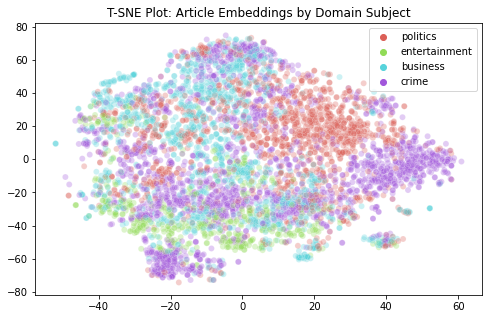

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Select document mean embedding only
df_embed = data['df_X'].loc[:,'Doc_BERT_D_0': 'Doc_BERT_D_767']
#Get doc labels
df_doc_label = pd.DataFrame(data['Xy_doc_label_array'],columns=['doc_label'])
#Match doc label to embedding and drop duplicate docs
df_tsne = pd.concat([df_doc_label, df_embed], axis=1)
df_tsne = df_tsne.drop_duplicates().set_index('doc_label', drop=True)

#Assign subject domain label
df_tsne['domain'] = data['domain_labels_arr']

X = df_tsne.values

#Separate labels and embeddings
X_tsne_embed = X[:, :-1]
X_tsne_labels = X[:,-1]

#Reduce dimension of embeddings with t-sne
X_tsne = TSNE(n_components=2).fit_transform(X_tsne_embed)

#assign to verticala nd horizontal axis
x = X_tsne[:,0]
y = X_tsne[:,1]
#set labels
labels = X_tsne_labels

#plot visualization
plt.figure(figsize=(8,5))
sns.scatterplot(x=x, y=y, hue=labels, 
                palette=sns.color_palette("hls", 4), legend="full",
                                                                    alpha=0.3);
plt.title('T-SNE Plot: Article Embeddings by Domain Subject');

Given the vast information loss of the representation (from n sentence embeddings to one article embedding to 2 dimensions) and the simple label assignment, we still clearly see regions of the embedding space dominated by different domains: bottome left clusters with politics, bottom right with crime, top right with entertainment and top left with business. The wide dispersion is also not surprising given that these categories are far from seperable and some articles will mixed topics like fraud (business crime), movie revenues (entertainment bussiness), etc. On this note, we can also spy a binary split in the data along the top left to bottom right diagonal. This puts politics and crime in the bottom half and business and entertainment in the top half. This could be interpreted in a number of ways (!) but the generous version would be that politics and crime both have a common focus on social and legaol matters while entertainment and bussiness are united by their commercial orientation.

We might also suspect that apparrent dispersion is influenced by imbalance in the sample. Low and behold, we see that crime represents nearly 38% of the sample and this could also explain why its dispersion appears more prominent.

In [10]:
df_domain_count = pd.DataFrame(df_tsne['domain'].value_counts(normalize=True))
df_domain_count.columns=['Normalized Count']
df_domain_count

,Normalized Count
crime,0.3760
politics,0.2648
business,0.2568
entertainment,0.1024


### Leading Sentences

It is a known phenomena that news articles typically use the leading sentences as the summary or teaser meaning that a simple strategy of always using the top 3 sentences for the summary is exceptionally difficult to beat for news corpus ROUGE scores.

In this section, we will investigate this phenomena within our particular corpus.

In [11]:
#flatten labels idx list
sent_numbers = np.concatenate(df.labels_idx_list)
#count sentence numbers
unique, counts = np.unique(sent_numbers, return_counts=True)
#Wrap in dataframe, noemalize and display first 10 sentences
norm_counts = pd.DataFrame(counts / counts.sum(), index=range(1,len(counts)+1),
                           columns = ['Normalized Count'])
norm_counts = norm_counts.apply(lambda x: round(x,3))
norm_counts.index.name= 'sent_number'
norm_counts['Cumulative'] = norm_counts.iloc[:,0].cumsum()
norm_counts.iloc[:10,:]




,Normalized Count,Cumulative
sent_number,,
1,0.196,0.196
2,0.167,0.363
3,0.138,0.501
4,0.105,0.606
5,0.076,0.682
6,0.052,0.734
7,0.038,0.772
8,0.025,0.797
9,0.020,0.817


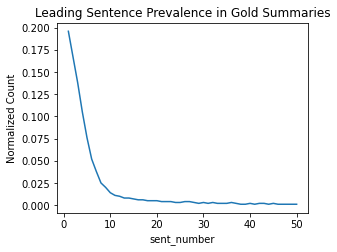

In [12]:
#plot normlaized count for first 
plt.figure(figsize=(4.5,3.5))
norm_counts['Normalized Count'].iloc[:50].plot(title='Leading Sentence Prevalence in Gold Summaries',
                                              ylabel='Normalized Count');

Not surprisingly, we see that our corpus shows this same structure with fully 50% of summary sentences (by our cosine measure) belonging to the leading 3 sentences. We also see a negative slope between sentence number and summary inclusion with the 7th sentence alreayd only comprising 3.8% of total compared to 10.5% for the 5th sentence.

In the next sections, we see if there is any marked variation in these statistics across subject domains or news publications.

### Leading Sentences Across Domain Subjects

In [13]:
#helper function to count items in list, normalize
#and wrap top 10 in dataframe
from collections import Counter

def list_to_df_norm_count(l):
    d_count= dict(Counter(l))
    df_count = pd.DataFrame(d_count.values(), index=d_count.keys(),
                       columns=['Normalized Count']) 

    df_count = (df_count / df_count.sum()).sort_values('Normalized Count',
                                                   ascending=False)
    df_count.index = range(1, len(df_count)+1)
    
    df_count = df_count.apply(lambda x: round(x,3))
    
    return df_count[:10]



In [14]:
#find normalized count of sentence index per subject domain

df_sent_dom = pd.DataFrame(df.labels_idx_list)
df_sent_dom['domain'] = data['domain_labels_arr']
df_sent_dom['labels_idx_list'] = df_sent_dom['labels_idx_list'].apply(list).values
df_sent_group = df_sent_dom.groupby('domain').sum()

df_sent_group = df_sent_group.labels_idx_list.apply(list_to_df_norm_count)


df_formatted = df_sent_group.iloc[0]
df_formatted.columns = [df_sent_group.index[0]]

for j in range(1,4):
    df_formatted[df_sent_group.index[j]] = df_sent_group.iloc[j].values
    
df_formatted.index.name = 'Normalized Count'

df_formatted


,business,crime,entertainment,politics
Normalized Count,,,,
1,0.180,0.187,0.201,0.225
2,0.163,0.148,0.163,0.203
3,0.143,0.118,0.132,0.163
4,0.109,0.091,0.098,0.125
5,0.082,0.068,0.067,0.086
6,0.059,0.050,0.051,0.047
7,0.047,0.034,0.051,0.029
8,0.029,0.025,0.033,0.016
9,0.022,0.023,0.024,0.014


While some variation is evident (top 3 sentences accounting for 59% for politics and 45% for crime), the general trend in individual and cumulative numbers looks fairly similar with no obvious outlier.

### Leading Sentences Publications

In [15]:
#find sentence number count by publication
top10_pubs = df_pubs.index.tolist()

#Wrangle df in format grouped by pubs and ready for helper function
df_sent_dom = pd.DataFrame(df.labels_idx_list)
df_sent_dom['pubs'] = df.url.apply(lambda x: x[x.find('www.')+4 : x.find('.com')]).values
df_sent_dom['labels_idx_list'] = df_sent_dom['labels_idx_list'].apply(list).values
df_sent_group = df_sent_dom.groupby('pubs').sum()

#Apply helper function
df_sent_group = df_sent_group.labels_idx_list.apply(list_to_df_norm_count)

#filter top 10 only
mask = df_sent_group.index.isin(top10_pubs)
df_sent_group = df_sent_group[mask]

#format dataframe for neat display
df_formatted = df_sent_group.iloc[0]
df_formatted.columns = [df_sent_group.index[0]]

for j in range(1, 10):
    df_formatted[df_sent_group.index[j]] = df_sent_group.iloc[j].values
    
df_formatted.index.name = 'Normalized Count'

df_formatted = df_formatted[top10_pubs]

df_formatted
 

,nytimes,bostonglobe,nydailynews,cnbc,9news,p://fortune,sfgate,p://nypost,tmz,aol
Normalized Count,,,,,,,,,,
1,0.191,0.214,0.166,0.264,0.524,0.256,0.031,0.433,0.535,0.262
2,0.170,0.181,0.165,0.177,0.302,0.249,0.029,0.273,0.206,0.230
3,0.169,0.137,0.128,0.119,0.102,0.198,0.027,0.090,0.111,0.142
4,0.143,0.105,0.125,0.088,0.033,0.090,0.025,0.032,0.045,0.065
5,0.103,0.089,0.092,0.065,0.011,0.028,0.025,0.015,0.025,0.049
6,0.066,0.065,0.074,0.055,0.011,0.016,0.025,0.015,0.025,0.032
7,0.042,0.051,0.048,0.044,0.007,0.015,0.025,0.013,0.019,0.026
8,0.028,0.026,0.027,0.032,0.004,0.015,0.024,0.009,0.017,0.016
9,0.019,0.025,0.021,0.030,0.004,0.010,0.024,0.009,0.006,0.016


We observe that the lead three sentence phenomena is very strong across all publications. In particular, a number of the news outlets or tabloids rely almost exclusively on this strategy. For example: nypost has 80%, 9news 90% and tmz 85%. 